In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as ss
from scipy.stats import gamma
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.patches import Rectangle
import seaborn.apionly as sns
from IPython.display import HTML
import os, glob, sys
import time
from line_profiler import LineProfiler
import warnings
warnings.simplefilter('always')

from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.plotting import figure 
output_notebook()

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Loading BokehJS ...

In [2]:
np.seterr(all='raise', divide='ignore', over='raise', under='ignore', invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
data1 = pd.read_csv('observation.csv')
data1 = data1.drop(['Unnamed: 0'],axis=1)

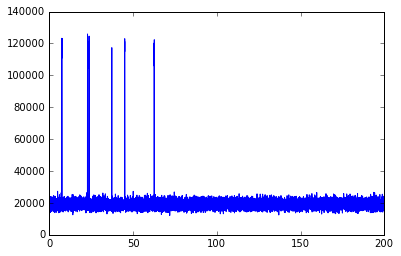

In [4]:
%matplotlib inline
plt.plot(data1['0'],data1['1'])

In [5]:
Wn = np.array(data1['1'])
N = len(Wn)  

In [6]:
Wn = Wn.reshape(1,19999)

In [7]:
repeats = 5000

In [8]:
hyper_param = {'alfa':1.0,'alfa1_proposal':150,'alfa1_prior':1.0,'alfa2_prior':1.0,
               'alfa2_proposal':200,'N_particles':1,'dt':0.01*0.95,'f':2.0} 

In [9]:
hyper_param['beta'] = 1.0/hyper_param['alfa']
hyper_param['beta1'] = 1e+3/hyper_param['alfa1_prior']
hyper_param['beta2'] = 1e+03/hyper_param['alfa2_prior']

In [10]:
M = hyper_param['N_particles']

In [11]:
Sn = pd.read_csv('trajectory.csv').drop('Unnamed: 0',axis=1).values

In [12]:
Ksn = np.where(Sn==1,10,0.0)   # Ksn[M,N]

In [13]:
np.shape(Ksn)

(1, 19999)

In [14]:
data = dict({'ite':[0],'E_b':[10],'E_ph':[10]})
accepted  = 0.0
accepted_rho = 0.0
accepted_ksigma2 = 0.0
f = hyper_param['f']
for j in range(1,repeats):
    print(j)
    rho_old = data['E_b'][j-1]
    k_sigma2_old = data['E_ph'][j-1]

    rho_prop = np.random.gamma(hyper_param['alfa1_proposal'],scale=rho_old/hyper_param['alfa1_proposal'])
    k_sigma2_prop = np.random.gamma(hyper_param['alfa2_proposal'],scale=k_sigma2_old/hyper_param['alfa2_proposal'])
#     rho_prop = rho_old
    
    proposal_ratio = ((2*hyper_param['alfa1_proposal']-1)*np.log(rho_old/rho_prop)+
                         hyper_param['alfa1_proposal']*(rho_prop/rho_old-rho_old/rho_prop)+
                      (2*hyper_param['alfa2_proposal']-1)*np.log(k_sigma2_old/k_sigma2_prop)+
                         hyper_param['alfa2_proposal']*(k_sigma2_prop/k_sigma2_old-k_sigma2_old/k_sigma2_prop))

    prior_ratio = ((hyper_param['alfa1_prior']-1)*np.log(rho_prop/rho_old)+(rho_old-rho_prop)/hyper_param['beta1']+
    (hyper_param['alfa2_prior']-1)*np.log(k_sigma2_prop/k_sigma2_old)+(k_sigma2_old-k_sigma2_prop)/hyper_param['beta2']) 

    # Likelihood ratio in log format      
    Ksn1 = np.where(Sn==1,k_sigma2_old,0.0)  # Old
    rate1 = (rho_old+Ksn1)*hyper_param['dt'] 

    Ksn2 = np.where(Sn==1,k_sigma2_prop,0.0)  # Prop
    rate2 = (rho_prop+Ksn2)*hyper_param['dt']     
        
    likelihood_ratio = (np.sum((rate2/f)*np.log(Wn/f)-scipy.special.loggamma(rate2/f))-
                      np.sum((rate1/f)*np.log(Wn/f)-scipy.special.loggamma(rate1/f))-
                      np.sum(rate2/f)*np.log(1./hyper_param['beta']+np.sum(Wn)/f)+
                      np.sum(rate1/f)*np.log(1./hyper_param['beta']+np.sum(Wn)/f)+
                      scipy.special.loggamma(hyper_param['alfa']+np.sum(rate2)/f)-
                      scipy.special.loggamma(hyper_param['alfa']+np.sum(rate1)/f))
        
    # Step (b)                                
    AR = likelihood_ratio+prior_ratio+proposal_ratio
        
    # Step (c)
    v = np.random.exponential(scale=1)
        
    # Step (d)
    if v>-AR:
        accepted = accepted + 1.0
        data['E_b'].append(rho_prop)
        data['E_ph'].append(k_sigma2_prop)
    else:
        data['E_b'].append(rho_old)
        data['E_ph'].append(k_sigma2_old)
        
    data['ite'].append(j)
    print(data['ite'][j],data['E_b'][j],data['E_ph'][j])
    
    
print(accepted*100/repeats)

1
1 10 10
2
2 10 10
3
3 10.655823890230927 8.700619193626821
4
4 10.655823890230927 8.700619193626821
5
5 11.342818363687252 9.001856760558603
6
6 11.55160312204951 8.931768578800085
7
7 11.903276741213622 8.347051570145526
8
8 13.462813180370645 8.450252681655394
9
9 13.462813180370645 8.450252681655394
10
10 13.462813180370645 8.450252681655394
11
11 13.462813180370645 8.450252681655394
12
12 13.462813180370645 8.450252681655394
13
13 13.462813180370645 8.450252681655394
14
14 13.462813180370645 8.450252681655394
15
15 15.475858272862427 8.348794460154132
16
16 15.475858272862427 8.348794460154132
17
17 15.674171429360575 8.157962129390882
18
18 15.674171429360575 8.157962129390882
19
19 15.674171429360575 8.157962129390882
20
20 17.04686757970541 9.187473327140596
21
21 17.04686757970541 9.187473327140596
22
22 17.373675547036783 8.970960402392558
23
23 17.373675547036783 8.970960402392558
24
24 17.373675547036783 8.970960402392558
25
25 18.255674760281916 9.708479801938312
26
26 19

247 5363.8602849290655 31.611436081900877
248
248 5363.8602849290655 31.611436081900877
249
249 5363.8602849290655 31.611436081900877
250
250 5363.8602849290655 31.611436081900877
251
251 5363.8602849290655 31.611436081900877
252
252 5363.8602849290655 31.611436081900877
253
253 5363.8602849290655 31.611436081900877
254
254 5363.8602849290655 31.611436081900877
255
255 5363.8602849290655 31.611436081900877
256
256 5364.452455659127 33.633400951817805
257
257 5364.452455659127 33.633400951817805
258
258 5364.452455659127 33.633400951817805
259
259 5364.452455659127 33.633400951817805
260
260 5364.452455659127 33.633400951817805
261
261 5364.452455659127 33.633400951817805
262
262 5364.452455659127 33.633400951817805
263
263 5100.688328873211 35.96814169644098
264
264 5037.050755887664 37.408058044050435
265
265 5137.391922619117 39.26403948308234
266
266 5137.391922619117 39.26403948308234
267
267 5137.391922619117 39.26403948308234
268
268 5137.391922619117 39.26403948308234
269
269 51

506 5278.550912830664 245.69640424961113
507
507 5001.429603574191 267.7263515238427
508
508 5509.217222061034 272.39732711700987
509
509 5509.217222061034 272.39732711700987
510
510 5509.217222061034 272.39732711700987
511
511 5509.217222061034 272.39732711700987
512
512 5509.217222061034 272.39732711700987
513
513 5509.217222061034 272.39732711700987
514
514 5433.590535284902 282.9253758083624
515
515 5433.590535284902 282.9253758083624
516
516 5433.590535284902 282.9253758083624
517
517 5433.590535284902 282.9253758083624
518
518 5575.663470913526 310.62456513185725
519
519 5575.663470913526 310.62456513185725
520
520 5575.663470913526 310.62456513185725
521
521 5529.859129203394 341.38952377968263
522
522 5529.859129203394 341.38952377968263
523
523 5529.859129203394 341.38952377968263
524
524 5529.859129203394 341.38952377968263
525
525 5529.859129203394 341.38952377968263
526
526 5247.044507419133 366.36653273211095
527
527 5247.044507419133 366.36653273211095
528
528 5247.044507

773 10427.62155141966 38145.29027179552
774
774 10216.994124705301 41123.296619355286
775
775 10216.994124705301 41123.296619355286
776
776 10216.994124705301 41123.296619355286
777
777 10574.1639921384 42131.71483505868
778
778 10574.1639921384 42131.71483505868
779
779 10574.1639921384 42131.71483505868
780
780 11710.665166799532 43384.1590073574
781
781 11710.665166799532 43384.1590073574
782
782 11106.494869738464 43636.27154948391
783
783 11727.533515264484 47077.113462850844
784
784 11238.109409382014 48202.987078838785
785
785 11238.109409382014 48202.987078838785
786
786 11696.837328605981 50947.688410841336
787
787 11696.837328605981 50947.688410841336
788
788 11610.109472201064 52943.43223829217
789
789 13369.434238970705 52791.103925229596
790
790 13369.434238970705 52791.103925229596
791
791 13369.434238970705 52791.103925229596
792
792 13369.434238970705 52791.103925229596
793
793 13369.434238970705 52791.103925229596
794
794 13369.434238970705 52791.103925229596
795
795 1

1070 19840.64096803051 98948.81467786217
1071
1071 19840.64096803051 98948.81467786217
1072
1072 19840.64096803051 98948.81467786217
1073
1073 19840.64096803051 98948.81467786217
1074
1074 19840.64096803051 98948.81467786217
1075
1075 19840.64096803051 98948.81467786217
1076
1076 19840.64096803051 98948.81467786217
1077
1077 19840.64096803051 98948.81467786217
1078
1078 19840.64096803051 98948.81467786217
1079
1079 19840.64096803051 98948.81467786217
1080
1080 19840.64096803051 98948.81467786217
1081
1081 19840.64096803051 98948.81467786217
1082
1082 19840.64096803051 98948.81467786217
1083
1083 19840.64096803051 98948.81467786217
1084
1084 19840.64096803051 98948.81467786217
1085
1085 19840.64096803051 98948.81467786217
1086
1086 19840.64096803051 98948.81467786217
1087
1087 19840.64096803051 98948.81467786217
1088
1088 19840.64096803051 98948.81467786217
1089
1089 19840.64096803051 98948.81467786217
1090
1090 19840.64096803051 98948.81467786217
1091
1091 19840.64096803051 98948.81467

1348 19789.162281933684 99649.96603292639
1349
1349 19789.162281933684 99649.96603292639
1350
1350 19789.162281933684 99649.96603292639
1351
1351 19789.162281933684 99649.96603292639
1352
1352 19789.162281933684 99649.96603292639
1353
1353 19789.162281933684 99649.96603292639
1354
1354 19789.162281933684 99649.96603292639
1355
1355 19789.162281933684 99649.96603292639
1356
1356 19789.162281933684 99649.96603292639
1357
1357 19789.162281933684 99649.96603292639
1358
1358 19789.162281933684 99649.96603292639
1359
1359 19789.162281933684 99649.96603292639
1360
1360 19789.162281933684 99649.96603292639
1361
1361 19789.162281933684 99649.96603292639
1362
1362 19789.162281933684 99649.96603292639
1363
1363 19789.162281933684 99649.96603292639
1364
1364 19789.162281933684 99649.96603292639
1365
1365 19789.162281933684 99649.96603292639
1366
1366 19789.162281933684 99649.96603292639
1367
1367 19789.162281933684 99649.96603292639
1368
1368 19789.162281933684 99649.96603292639
1369
1369 19789.16

1631 19579.18996421529 97990.39706824445
1632
1632 19843.783598423346 99419.57512601247
1633
1633 19843.783598423346 99419.57512601247
1634
1634 19843.783598423346 99419.57512601247
1635
1635 19843.783598423346 99419.57512601247
1636
1636 19843.783598423346 99419.57512601247
1637
1637 19843.783598423346 99419.57512601247
1638
1638 19843.783598423346 99419.57512601247
1639
1639 19843.783598423346 99419.57512601247
1640
1640 19843.783598423346 99419.57512601247
1641
1641 19843.783598423346 99419.57512601247
1642
1642 19843.783598423346 99419.57512601247
1643
1643 19843.783598423346 99419.57512601247
1644
1644 19843.783598423346 99419.57512601247
1645
1645 19843.783598423346 99419.57512601247
1646
1646 19843.783598423346 99419.57512601247
1647
1647 19843.783598423346 99419.57512601247
1648
1648 19843.783598423346 99419.57512601247
1649
1649 19843.783598423346 99419.57512601247
1650
1650 19843.783598423346 99419.57512601247
1651
1651 19843.783598423346 99419.57512601247
1652
1652 19843.783

1903 19823.29543381461 100087.3471390462
1904
1904 19823.29543381461 100087.3471390462
1905
1905 19823.29543381461 100087.3471390462
1906
1906 19823.29543381461 100087.3471390462
1907
1907 19823.29543381461 100087.3471390462
1908
1908 19823.29543381461 100087.3471390462
1909
1909 19823.29543381461 100087.3471390462
1910
1910 19823.29543381461 100087.3471390462
1911
1911 19823.29543381461 100087.3471390462
1912
1912 19823.29543381461 100087.3471390462
1913
1913 19823.29543381461 100087.3471390462
1914
1914 19823.29543381461 100087.3471390462
1915
1915 19823.29543381461 100087.3471390462
1916
1916 19823.29543381461 100087.3471390462
1917
1917 19823.29543381461 100087.3471390462
1918
1918 19823.29543381461 100087.3471390462
1919
1919 19823.29543381461 100087.3471390462
1920
1920 19823.29543381461 100087.3471390462
1921
1921 19823.29543381461 100087.3471390462
1922
1922 19823.29543381461 100087.3471390462
1923
1923 19823.29543381461 100087.3471390462
1924
1924 19823.29543381461 100087.3471

2176 19859.529762634666 99047.51414583687
2177
2177 19859.529762634666 99047.51414583687
2178
2178 19859.529762634666 99047.51414583687
2179
2179 19859.529762634666 99047.51414583687
2180
2180 19859.529762634666 99047.51414583687
2181
2181 19859.529762634666 99047.51414583687
2182
2182 19859.529762634666 99047.51414583687
2183
2183 19859.529762634666 99047.51414583687
2184
2184 19859.529762634666 99047.51414583687
2185
2185 19859.529762634666 99047.51414583687
2186
2186 19859.529762634666 99047.51414583687
2187
2187 19859.529762634666 99047.51414583687
2188
2188 19859.529762634666 99047.51414583687
2189
2189 19859.529762634666 99047.51414583687
2190
2190 19859.529762634666 99047.51414583687
2191
2191 19859.529762634666 99047.51414583687
2192
2192 19859.529762634666 99047.51414583687
2193
2193 19859.529762634666 99047.51414583687
2194
2194 19859.529762634666 99047.51414583687
2195
2195 19859.529762634666 99047.51414583687
2196
2196 19859.529762634666 99047.51414583687
2197
2197 19859.52

2475 19722.88282686173 98765.26497895061
2476
2476 19722.88282686173 98765.26497895061
2477
2477 19722.88282686173 98765.26497895061
2478
2478 19722.88282686173 98765.26497895061
2479
2479 19722.88282686173 98765.26497895061
2480
2480 19722.88282686173 98765.26497895061
2481
2481 19722.88282686173 98765.26497895061
2482
2482 19722.88282686173 98765.26497895061
2483
2483 19722.88282686173 98765.26497895061
2484
2484 19722.88282686173 98765.26497895061
2485
2485 19722.88282686173 98765.26497895061
2486
2486 19722.88282686173 98765.26497895061
2487
2487 19722.88282686173 98765.26497895061
2488
2488 19722.88282686173 98765.26497895061
2489
2489 19722.88282686173 98765.26497895061
2490
2490 19722.88282686173 98765.26497895061
2491
2491 19722.88282686173 98765.26497895061
2492
2492 19722.88282686173 98765.26497895061
2493
2493 19722.88282686173 98765.26497895061
2494
2494 19722.88282686173 98765.26497895061
2495
2495 19722.88282686173 98765.26497895061
2496
2496 19722.88282686173 98765.26497

2757 19722.88282686173 98765.26497895061
2758
2758 19722.88282686173 98765.26497895061
2759
2759 19722.88282686173 98765.26497895061
2760
2760 19722.88282686173 98765.26497895061
2761
2761 19722.88282686173 98765.26497895061
2762
2762 19722.88282686173 98765.26497895061
2763
2763 19722.88282686173 98765.26497895061
2764
2764 19722.88282686173 98765.26497895061
2765
2765 19722.88282686173 98765.26497895061
2766
2766 19722.88282686173 98765.26497895061
2767
2767 19722.88282686173 98765.26497895061
2768
2768 19722.88282686173 98765.26497895061
2769
2769 19722.88282686173 98765.26497895061
2770
2770 19722.88282686173 98765.26497895061
2771
2771 19722.88282686173 98765.26497895061
2772
2772 19722.88282686173 98765.26497895061
2773
2773 19722.88282686173 98765.26497895061
2774
2774 19722.88282686173 98765.26497895061
2775
2775 19722.88282686173 98765.26497895061
2776
2776 19722.88282686173 98765.26497895061
2777
2777 19722.88282686173 98765.26497895061
2778
2778 19722.88282686173 98765.26497

3043 19722.88282686173 98765.26497895061
3044
3044 19722.88282686173 98765.26497895061
3045
3045 19722.88282686173 98765.26497895061
3046
3046 19722.88282686173 98765.26497895061
3047
3047 19722.88282686173 98765.26497895061
3048
3048 19722.88282686173 98765.26497895061
3049
3049 19722.88282686173 98765.26497895061
3050
3050 19722.88282686173 98765.26497895061
3051
3051 19722.88282686173 98765.26497895061
3052
3052 19722.88282686173 98765.26497895061
3053
3053 19722.88282686173 98765.26497895061
3054
3054 19722.88282686173 98765.26497895061
3055
3055 19722.88282686173 98765.26497895061
3056
3056 19722.88282686173 98765.26497895061
3057
3057 19722.88282686173 98765.26497895061
3058
3058 19722.88282686173 98765.26497895061
3059
3059 19887.81633907338 98405.11535452688
3060
3060 19887.81633907338 98405.11535452688
3061
3061 19838.594596857783 98635.88134934424
3062
3062 19838.594596857783 98635.88134934424
3063
3063 19838.594596857783 98635.88134934424
3064
3064 19838.594596857783 98635.8

3338 19537.67834978523 97964.59800702342
3339
3339 19537.67834978523 97964.59800702342
3340
3340 19537.67834978523 97964.59800702342
3341
3341 19537.67834978523 97964.59800702342
3342
3342 19537.67834978523 97964.59800702342
3343
3343 19537.67834978523 97964.59800702342
3344
3344 19537.67834978523 97964.59800702342
3345
3345 19537.67834978523 97964.59800702342
3346
3346 19537.67834978523 97964.59800702342
3347
3347 19537.67834978523 97964.59800702342
3348
3348 19537.67834978523 97964.59800702342
3349
3349 19537.67834978523 97964.59800702342
3350
3350 19537.67834978523 97964.59800702342
3351
3351 19537.67834978523 97964.59800702342
3352
3352 19537.67834978523 97964.59800702342
3353
3353 19537.67834978523 97964.59800702342
3354
3354 19537.67834978523 97964.59800702342
3355
3355 19537.67834978523 97964.59800702342
3356
3356 19537.67834978523 97964.59800702342
3357
3357 19537.67834978523 97964.59800702342
3358
3358 19537.67834978523 97964.59800702342
3359
3359 19537.67834978523 97964.59800

3636 19615.372548886306 98672.21242094073
3637
3637 19615.372548886306 98672.21242094073
3638
3638 19615.372548886306 98672.21242094073
3639
3639 19615.372548886306 98672.21242094073
3640
3640 19615.372548886306 98672.21242094073
3641
3641 19615.372548886306 98672.21242094073
3642
3642 19615.372548886306 98672.21242094073
3643
3643 19615.372548886306 98672.21242094073
3644
3644 19615.372548886306 98672.21242094073
3645
3645 19615.372548886306 98672.21242094073
3646
3646 19615.372548886306 98672.21242094073
3647
3647 19615.372548886306 98672.21242094073
3648
3648 19615.372548886306 98672.21242094073
3649
3649 19615.372548886306 98672.21242094073
3650
3650 19615.372548886306 98672.21242094073
3651
3651 19615.372548886306 98672.21242094073
3652
3652 19615.372548886306 98672.21242094073
3653
3653 19615.372548886306 98672.21242094073
3654
3654 19615.372548886306 98672.21242094073
3655
3655 19615.372548886306 98672.21242094073
3656
3656 19615.372548886306 98672.21242094073
3657
3657 19615.37

3891 19763.541586832987 100167.20961109542
3892
3892 19763.541586832987 100167.20961109542
3893
3893 19763.541586832987 100167.20961109542
3894
3894 19763.541586832987 100167.20961109542
3895
3895 19763.541586832987 100167.20961109542
3896
3896 19763.541586832987 100167.20961109542
3897
3897 19763.541586832987 100167.20961109542
3898
3898 19763.541586832987 100167.20961109542
3899
3899 19763.541586832987 100167.20961109542
3900
3900 19763.541586832987 100167.20961109542
3901
3901 19763.541586832987 100167.20961109542
3902
3902 19763.541586832987 100167.20961109542
3903
3903 19763.541586832987 100167.20961109542
3904
3904 19763.541586832987 100167.20961109542
3905
3905 19763.541586832987 100167.20961109542
3906
3906 19763.541586832987 100167.20961109542
3907
3907 19763.541586832987 100167.20961109542
3908
3908 19763.541586832987 100167.20961109542
3909
3909 19960.066345586267 99291.88911712219
3910
3910 19960.066345586267 99291.88911712219
3911
3911 19960.066345586267 99291.88911712219


4169 19597.996593733566 97411.92179174612
4170
4170 19597.996593733566 97411.92179174612
4171
4171 19597.996593733566 97411.92179174612
4172
4172 19597.996593733566 97411.92179174612
4173
4173 19597.996593733566 97411.92179174612
4174
4174 19597.996593733566 97411.92179174612
4175
4175 19597.996593733566 97411.92179174612
4176
4176 19597.996593733566 97411.92179174612
4177
4177 19597.996593733566 97411.92179174612
4178
4178 19597.996593733566 97411.92179174612
4179
4179 19597.996593733566 97411.92179174612
4180
4180 19597.996593733566 97411.92179174612
4181
4181 19597.996593733566 97411.92179174612
4182
4182 19597.996593733566 97411.92179174612
4183
4183 19597.996593733566 97411.92179174612
4184
4184 19597.996593733566 97411.92179174612
4185
4185 19597.996593733566 97411.92179174612
4186
4186 19597.996593733566 97411.92179174612
4187
4187 19597.996593733566 97411.92179174612
4188
4188 19597.996593733566 97411.92179174612
4189
4189 19597.996593733566 97411.92179174612
4190
4190 19597.99

4452 19517.74199010132 97051.39676119883
4453
4453 19517.74199010132 97051.39676119883
4454
4454 19517.74199010132 97051.39676119883
4455
4455 19937.75646038006 100220.09875972824
4456
4456 19937.75646038006 100220.09875972824
4457
4457 19937.75646038006 100220.09875972824
4458
4458 19937.75646038006 100220.09875972824
4459
4459 19937.75646038006 100220.09875972824
4460
4460 19937.75646038006 100220.09875972824
4461
4461 19937.75646038006 100220.09875972824
4462
4462 19937.75646038006 100220.09875972824
4463
4463 19937.75646038006 100220.09875972824
4464
4464 19937.75646038006 100220.09875972824
4465
4465 19937.75646038006 100220.09875972824
4466
4466 19937.75646038006 100220.09875972824
4467
4467 19937.75646038006 100220.09875972824
4468
4468 19937.75646038006 100220.09875972824
4469
4469 19937.75646038006 100220.09875972824
4470
4470 19937.75646038006 100220.09875972824
4471
4471 19937.75646038006 100220.09875972824
4472
4472 19937.75646038006 100220.09875972824
4473
4473 19937.75646

4737 19515.76707568312 98043.50242372921
4738
4738 19515.76707568312 98043.50242372921
4739
4739 19515.76707568312 98043.50242372921
4740
4740 19515.76707568312 98043.50242372921
4741
4741 19515.76707568312 98043.50242372921
4742
4742 19515.76707568312 98043.50242372921
4743
4743 19515.76707568312 98043.50242372921
4744
4744 19515.76707568312 98043.50242372921
4745
4745 19515.76707568312 98043.50242372921
4746
4746 19515.76707568312 98043.50242372921
4747
4747 19515.76707568312 98043.50242372921
4748
4748 19515.76707568312 98043.50242372921
4749
4749 19515.76707568312 98043.50242372921
4750
4750 19515.76707568312 98043.50242372921
4751
4751 19515.76707568312 98043.50242372921
4752
4752 19515.76707568312 98043.50242372921
4753
4753 19515.76707568312 98043.50242372921
4754
4754 19515.76707568312 98043.50242372921
4755
4755 19515.76707568312 98043.50242372921
4756
4756 19515.76707568312 98043.50242372921
4757
4757 19515.76707568312 98043.50242372921
4758
4758 19515.76707568312 98043.50242

In [15]:
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))

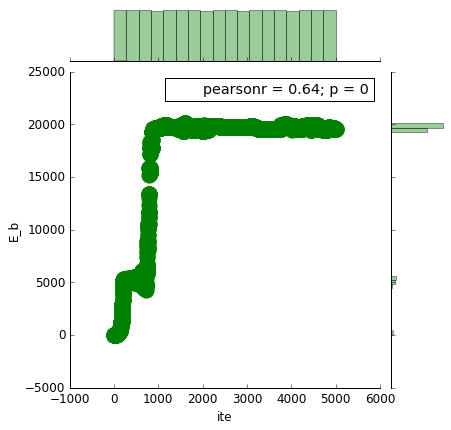

In [16]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_b'], kind='scatter',color='g',s =200,linewidth=2)
sns.set(style="darkgrid", color_codes=False)

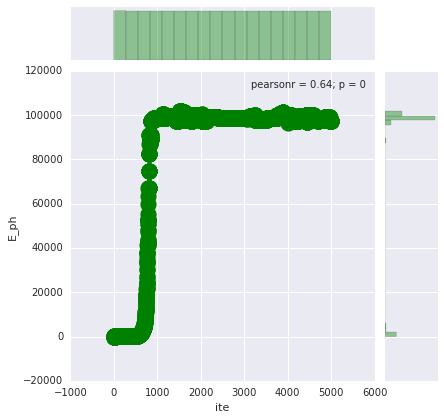

In [17]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_ph'], kind='scatter',color='g',s=200,linewidth=2)

In [ ]:
rho_b = np.random.gamma(hyper_param['alfa1_proposal'],scale=20000/hyper_param['alfa1_proposal'])
k_sigma2 = np.random.gamma(hyper_param['alfa2_proposal'],scale=100000/hyper_param['alfa2_proposal'])

In [ ]:
rho_b

In [ ]:
k_sigma2

In [ ]:
Ksn = np.where(Sn==1,k_sigma2,0.0)   # Ksn[M,N]

In [ ]:
g = 1./np.random.gamma(1,0.01)

In [ ]:
g

In [ ]:
np.array_equal(np.dot(params['bm'][0,:],Ksn).reshape(1,19999),Ksn)

In [ ]:
un = (rho_b+np.dot(params['bm'][0,:],Ksn).reshape(1,19999))*hyper_param['dt']

In [ ]:
Wn = np.random.gamma(un/2,2*g)

In [ ]:
Wn[0]

In [ ]:
n, bins, patches = plt.hist(Wn[0], 500, facecolor='blue')

In [ ]:
plt.scatter(range(len(Wn[0])), Wn[0], color="blue", alpha=0.5)